# Import libraries

In [1]:
#Import python libs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import random
import scipy.optimize as opt
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18})

# Define functions

In [50]:
def calc_CCC(sim,est):
    """
    This function calculate the correspondance correlation coefficient
    """
    #Claculate rho
    r, _ = stats.pearsonr(sim,est)

    #Calculate CCC
    CCC = (2*r*np.std(sim)*np.std(est)) / ((np.mean(sim) - np.mean(est))**2 + (np.var(sim) + np.var(est)))

    return CCC

In [51]:
def UniqueVals(stims, responses):
    
    """
    Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [52]:
def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    psi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    nll = -ll
    
    return nll

In [53]:
def Fit_psi(stims, Kleft, Nstims, Num_Inits):
    """
    Definition: Uses MLE to fit a psychometric function (normcdf) to data
    
    inputs:
    stims = vector of all stimulus values 
    responses = vector of all responses
    Num_Inits = number of initializations
    
    outputs:
    best_params = best paramers (size 2 vector)
    best_ll = log likelihood of the best parameters
    """   
    
    temp_ll = []
    temp_params = np.empty((Num_Inits,2))
    for i in range(Num_Inits):

        x0 = [norm.rvs(0,20), expon.rvs(0,20)]
        res = opt.minimize(nloglik, x0=x0, args=(stims,Nstims,Kleft),
                method='Nelder-Mead', bounds=((-50,50),(0,50)), options={'disp': False})
        
        temp_ll = np.append(temp_ll, res.fun)
        temp_params[i,:] = res.x

    min_idx = np.nanargmin(temp_ll)
    best_params = temp_params[min_idx]
    best_ll = temp_ll[min_idx]
    
    return best_params, best_ll

In [54]:
def sim_constants(params, X, num_trials):
    """
    """
    
    alpha = params[0]
    beta = params[1]
    
    p_left, Kleft = [], []
    for x in X:
        
        psi = norm.cdf(x, alpha, beta) 
        responses = psi > np.random.rand(num_trials)
        Kleft = np.append(Kleft, sum(responses))
        p_left = np.append(p_left, sum(responses)/num_trials)
        
    return Kleft, p_left     

In [55]:
#Look up table
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    
    # #Set these nuisance parameters to nonzero values
    # gam = 0.02
    # lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = norm.cdf(x,a,b)
                # psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[b_i,a_i,x_i] = psi
                p_right_look[b_i,a_i,x_i] = 1-psi

    return p_left_look, p_right_look

In [7]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH, Post_left, Post_right = [], [], []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = p_left_look[:,:,i]*Prior
        Post_left = Post_left / p_left
        Post_right = p_right_look[:,:,i]*Prior
        Post_right = Post_right / p_right

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
        H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    
    return EH, best_X

In [8]:
def calc_CCC(sim,est):
    """
    This function calculate the correspondance correlation coefficient
    """
    #Claculate rho
    r, _ = stats.pearsonr(sim,est)

    #Calculate CCC
    CCC = (2*r*np.std(sim)*np.std(est)) / ((np.mean(sim) - np.mean(est))**2 + (np.var(sim) + np.var(est)))

    return CCC

In [9]:
def sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior):
    
    alpha = params[0]
    beta = params[1]
    
    stims, responses, alpha_EV, beta_EV = [], [], [], []
    for i in range(Ntrials):
        
        #Calculate the best stim position
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)
        
        #Simualte a response based on the parameters
        responses = np.append(responses, norm.cdf(best_X, alpha, beta) > np.random.rand())

        #Index the posterior
        stim_idx = np.argwhere(stims[i]==X)[0][0]
        if responses[i]==1:
            Posterior = p_left_look[:,:,stim_idx]*Prior
        elif responses[i]==0:
            Posterior = p_right_look[:,:,stim_idx]*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=0)
        beta_post = np.nansum(Posterior,axis=1)

        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))

        #The posterior becomes the prior for the next trial
        Prior = Posterior        
        
    return stims, responses, alpha_EV, beta_EV

# Set variables for each method

## Set the lookup table and the prior (for psi method)

In [32]:
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100,201) 
b_range = np.linspace(0.001,100,201)
p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))
Prior = p_beta.T @ p_alpha 

## Set stimuli range for the method of constants

In [33]:
#Logspace the array so it can cover a wider space
X_constants = np.round(np.logspace(1,2,4))
X_constants = np.concatenate((-np.flip(X_constants), np.zeros(1), X_constants))
X_constants

array([-100.,  -46.,  -22.,  -10.,    0.,   10.,   22.,   46.,  100.])

# Simulate an individual

For a fair comparison, we should make an equal number of trials. To give the method of constants a chance, we should run at least 10 simulations per stim location, a total of 90 trials given the 9 different stimulus locations. 

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
/var/fol

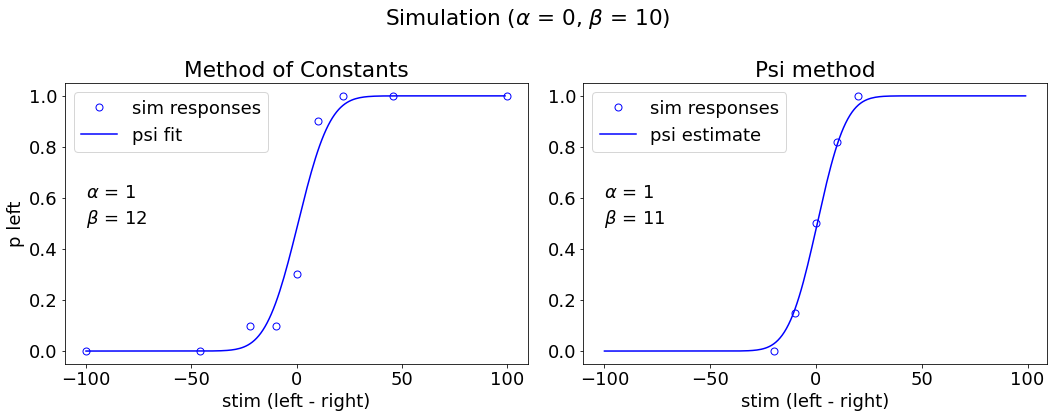

In [43]:
#Set the parameters
alpha, beta = 0, 10
params = [alpha, beta]

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

#Simulate Psi
stims, responses, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
psi_psi = norm.cdf(np.arange(-100,100), alpha_EV[-1], beta_EV[-1])
unique_stims, Nstims_psi, Kleft_psi = UniqueVals(stims, responses)

#Simulate Constants 
Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)

#Fit the constants data
Nstims = np.ones_like(X_constants)*trials_per_stim
best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)
psi_constants = norm.cdf(np.arange(-100,100),best_params[0],best_params[1])

#Plot
fig, ax = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
ax[0].plot(X_constants, p_left, 'bo', mfc='w', ms=7, label='sim responses')
ax[0].plot(np.arange(-100,100), psi_constants, 'b', label='psi fit')
ax[0].text(-100,0.6, r'$\alpha$ = ' + str(round(best_params[0])))
ax[0].text(-100,0.5, r'$\beta$ = ' + str(round(best_params[1])))
ax[0].set(title='Method of Constants', ylabel='p left', xlabel='stim (left - right)')
ax[0].legend()

ax[1].plot(unique_stims, Kleft_psi/Nstims_psi, 'bo', mfc='w', ms=7, label='sim responses')
ax[1].plot(np.arange(-100,100), psi_psi, 'b', label='psi estimate')
ax[1].text(-100,0.6, r'$\alpha$ = ' + str(round(alpha_EV[-1])))
ax[1].text(-100,0.5, r'$\beta$ = ' + str(round(beta_EV[-1])))
ax[1].set(title='Psi method', xlabel='stim (left - right)')
ax[1].legend()
fig.suptitle(r'Simulation ($\alpha$ = ' + str(alpha) + r', $\beta$ = ' + str(beta) + ')')
plt.show()

# Simulate a group of individulas (randomized parameters) 

In [71]:
#Number of sims per alpha and beta
Nsubjs = 50

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

In [72]:
alpha_sim, beta_sim, alpha_psi, beta_psi, alpha_constants, beta_constants = [],[],[],[],[],[]
for n in range(Nsubjs):

    alpha_sim = np.append(alpha_sim, norm.rvs(0,20))
    beta_sim = np.append(beta_sim, expon.rvs(0,20))
    params = [alpha_sim[n], beta_sim[n]]
    
    #Simulate Psi
    _, _, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_psi = np.append(alpha_psi, alpha_EV[-1]) 
    beta_psi = np.append(beta_psi, beta_EV[-1])

    #Simulate Constants 
    Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)
    #Fit the constants data
    Nstims = np.ones_like(X_constants)*trials_per_stim
    best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)

    alpha_constants = np.append(alpha_constants, best_params[0])
    beta_constants = np.append(beta_constants, best_params[1])

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
/var/fol

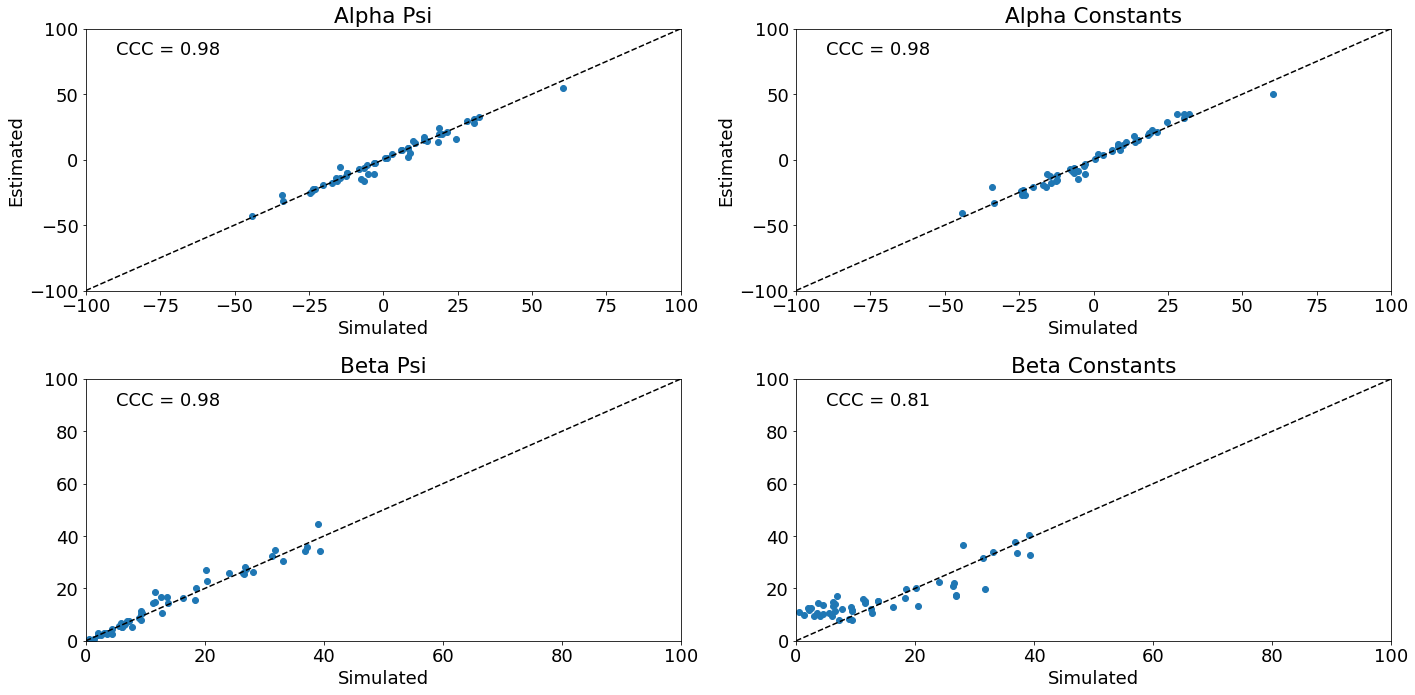

In [73]:
alpha_psi_ccc = calc_CCC(alpha_sim,alpha_psi)
alpha_const_ccc = calc_CCC(alpha_sim,alpha_constants)
beta_psi_ccc = calc_CCC(beta_sim,beta_psi)
beta_const_ccc = calc_CCC(beta_sim,beta_constants)

#Plot
fig, ax = plt.subplots(2,2,figsize=(20,10), tight_layout=True)
ax[0,0].plot(alpha_sim,alpha_psi,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].text(-90,80,'CCC = ' + str(round(alpha_psi_ccc,2)))
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Psi')

ax[1,0].plot(beta_sim,beta_psi,'o')
ax[1,0].plot(b_range,b_range,'k--')
ax[1,0].text(5,90,'CCC = ' + str(round(beta_psi_ccc,2)))
ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Psi')

ax[0,1].plot(alpha_sim,alpha_constants,'o')
ax[0,1].plot(a_range,a_range,'k--')
ax[0,1].text(-90,80,'CCC = ' + str(round(alpha_const_ccc,2)))
ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Constants')

ax[1,1].plot(beta_sim,beta_constants,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].text(5,90,'CCC = ' + str(round(beta_const_ccc,2)))
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Constants')
plt.show()

# Simulate Group of individuals (pre-set parameters)

In [74]:
#Preset parameters
alphas = np.arange(-50,55,5)
betas = np.arange(0,55,5)

#Number of sims per alpha and beta
Nsubjs = 1

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

In [77]:
len(alphas)*len(betas)

231

In [78]:
alpha_sim, beta_sim, alpha_psi, beta_psi, alpha_constants, beta_constants = [],[],[],[],[],[]
for a in alphas:
    for b in betas:
        for n in range(Nsubjs):
            
            alpha_sim = np.append(alpha_sim, a)
            beta_sim = np.append(beta_sim, b)
            
            params = [a,b]
            
            #Simulate Psi
            _, _, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
            alpha_psi = np.append(alpha_psi, alpha_EV[-1]) 
            beta_psi = np.append(beta_psi, beta_EV[-1])

            #Simulate Constants 
            Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)
            #Fit the constants data
            Nstims = np.ones_like(X_constants)*trials_per_stim
            best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)
            
            alpha_constants = np.append(alpha_constants, best_params[0])
            beta_constants = np.append(beta_constants, best_params[1])

/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
/var/folders/_k/rrjsl6l55458lj1dgdxxphbm0000gn/T/ipykernel_30167/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
/var/fol